In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = '../../../data/rossmann-structured/'

## CLEANING AND FEATURE ENGINEERING

In [4]:
os.listdir(PATH)

['_dfs_fastai_processed',
 'store.csv',
 '.ipynb_checkpoints',
 '_archive',
 'state_names.csv',
 'googletrend.csv',
 'weather.csv',
 'store_states.csv',
 '_df',
 'models',
 'train.csv',
 'test.csv',
 'tmp']

In [5]:
csv_names = ['store.csv',
 'state_names.csv',
 'googletrend.csv',
 'weather.csv',
 'store_states.csv',
 'train.csv',
 'test.csv']

data_frames_table = []

In [6]:
for name in csv_names:
    data_frames_table.append(pd.read_csv(f'{PATH}{name}',low_memory=False))

In [7]:
len(data_frames_table)

7

In [8]:
for df in data_frames_table:
    display(df.head())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
store,state_names,googletrend,weather,store_states,train,test=data_frames_table

In [10]:
train.StateHoliday = train.StateHoliday!='0'
train.SchoolHoliday = train.SchoolHoliday!=0
test.StateHoliday = test.StateHoliday!='0'
test.SchoolHoliday = test.SchoolHoliday!=0

In [11]:
def join_df(df_left,df_right,left_on,right_on=None,how='left',suffix='_X'):
    if right_on==None: right_on=left_on
    return pd.merge(left=df_left,right=df_right,left_on=left_on,
                    right_on=right_on,how=how,suffixes=('',suffix))

In [12]:
store_states = join_df(store_states,state_names,left_on='State')

In [13]:
joined_df = join_df(train,store_states,left_on='Store')
joined_df_test = join_df(test,store_states,left_on='Store')

In [14]:
len(joined_df[joined_df['StateName'].isna()]),len(joined_df_test[joined_df_test['StateName'].isna()])

(0, 0)

In [15]:
joined_df = join_df(joined_df,store,left_on='Store')
joined_df_test = join_df(joined_df_test,store,left_on='Store')

In [16]:
len(joined_df[joined_df['StoreType'].isna()]),len(joined_df_test[joined_df_test['StoreType'].isna()])

(0, 0)

In [17]:
joined_df = join_df(joined_df,weather,left_on=['Date','StateName'],right_on=['Date','file'])
joined_df_test = join_df(joined_df_test,weather,left_on=['Date','StateName'],right_on=['Date','file'])

In [18]:
len(joined_df[joined_df['Max_TemperatureC'].isna()]),len(joined_df_test[joined_df_test['Max_TemperatureC'].isna()])

(0, 0)

In [19]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]

In [20]:
googletrend['State'] = googletrend['file'].apply(lambda file: file.split('_')[-1])

In [21]:
googletrend.loc[googletrend['State']=='NI','State']='HB,NI'

In [22]:
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


In [23]:
add_datepart(joined_df, "Date", drop=False)
add_datepart(joined_df_test, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)

In [24]:
joined_df = join_df(joined_df, googletrend, ["State","Year","Week"])
joined_df_test = join_df(joined_df_test, googletrend, ["State","Year","Week"])

In [25]:
len(joined_df[joined_df.trend.isnull()]),len(joined_df_test[joined_df_test.trend.isnull()])

(0, 0)

In [26]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [27]:
joined_df = join_df(joined_df, trend_de[['trend','Year','Week']], ["Year", "Week"], suffix='_DE')
joined_df_test = join_df(joined_df_test, trend_de[['trend','Year','Week']], ["Year", "Week"], suffix='_DE')

In [28]:
len(joined_df[joined_df.trend_DE.isnull()]),len(joined_df_test[joined_df_test.trend_DE.isnull()])

(0, 0)

In [29]:
joined_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'State', 'StateName', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'file', 'Max_TemperatureC',
       'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC',
       'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 

In [30]:
for df in (joined_df,joined_df_test):
    for column in df.columns:
        if column.endswith('_X'):
            df.drop(column,axis=1,inplace=True)

### Missing Values processing

In [31]:
joined_df.isnull().values.any(),joined_df_test.isnull().values.any()

(True, True)

In [32]:
joined_df.columns[joined_df.isna().any()].tolist(),joined_df_test.columns[joined_df_test.isna().any()].tolist()

(['CompetitionDistance',
  'CompetitionOpenSinceMonth',
  'CompetitionOpenSinceYear',
  'Promo2SinceWeek',
  'Promo2SinceYear',
  'PromoInterval',
  'Max_VisibilityKm',
  'Mean_VisibilityKm',
  'Min_VisibilitykM',
  'Max_Gust_SpeedKm_h',
  'CloudCover',
  'Events'],
 ['Open',
  'CompetitionDistance',
  'CompetitionOpenSinceMonth',
  'CompetitionOpenSinceYear',
  'Promo2SinceWeek',
  'Promo2SinceYear',
  'PromoInterval',
  'Max_VisibilityKm',
  'Mean_VisibilityKm',
  'Min_VisibilitykM',
  'Max_Gust_SpeedKm_h',
  'CloudCover',
  'Events'])

In [33]:
for df in (joined_df,joined_df_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [34]:
joined_df.columns[joined_df.isna().any()].tolist(),joined_df_test.columns[joined_df_test.isna().any()].tolist()

(['CompetitionDistance',
  'PromoInterval',
  'Max_VisibilityKm',
  'Mean_VisibilityKm',
  'Min_VisibilitykM',
  'Max_Gust_SpeedKm_h',
  'CloudCover',
  'Events'],
 ['Open',
  'CompetitionDistance',
  'PromoInterval',
  'Max_VisibilityKm',
  'Mean_VisibilityKm',
  'Min_VisibilitykM',
  'Max_Gust_SpeedKm_h',
  'CloudCover',
  'Events'])

In [35]:
for df in (joined_df,joined_df_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [36]:
for df in (joined_df,joined_df_test):
    df.loc[df["CompetitionDaysOpen"]<0,'CompetitionDaysOpen']=0
    df.loc[df.CompetitionOpenSinceYear==1900,'CompetitionDaysOpen']=0

In [37]:
for df in (joined_df,joined_df_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_df.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

In [38]:
for df in (joined_df,joined_df_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [39]:
for df in (joined_df,joined_df_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [40]:
joined_df.to_feather(f'{PATH}_df/joined_df_1')
joined_df_test.to_feather(f'{PATH}_df/joined_df_1_test')

### Durations
- days past state&school holiday, promo
- days to state&school holiday, promo
- running number of days of state&school holiday, promo in (b) week BEFORE
- running number of days of state&school holiday, promo in (f) week FOLLOWING

In [724]:
joined_df=pd.read_feather(f'{PATH}_df/joined_df_1')
joined_df_test=pd.read_feather(f'{PATH}_df/joined_df_1_test')

In [725]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [726]:
#df = train[columns]
df = train[columns].append(test[columns])

In [727]:
df.Date = df['Date'].apply(pd.to_datetime)

In [728]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [729]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [730]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [731]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [732]:
df = df.set_index("Date")

In [733]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [734]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()


In [735]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [736]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [737]:
df.reset_index(inplace=True)

In [738]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [739]:
df.drop(columns,1,inplace=True)

In [740]:
df.to_feather(f'{PATH}_df/_df_working')

In [741]:
df = pd.read_feather(f'{PATH}_df/_df_working')

In [742]:
df["Date"] = pd.to_datetime(df.Date)

In [743]:
df.columns.tolist()

['Date',
 'Store',
 'AfterSchoolHoliday',
 'BeforeSchoolHoliday',
 'AfterStateHoliday',
 'BeforeStateHoliday',
 'AfterPromo',
 'BeforePromo',
 'SchoolHoliday_bw',
 'StateHoliday_bw',
 'Promo_bw',
 'SchoolHoliday_fw',
 'StateHoliday_fw',
 'Promo_fw']

In [744]:
joined_df = join_df(joined_df, df, ['Store', 'Date'])
joined_df_test = join_df(joined_df_test, df, ['Store', 'Date'])

In [745]:
#ORIGINAL
#remove those where sales=0
#joined_df = joined_df[joined_df.Sales!=0]

#UPDATE
#joined_df.loc[joined_df.Sales==0,'Sales']=1

In [746]:
joined_df.reset_index(inplace=True)
joined_df_test.reset_index(inplace=True)

In [747]:
joined_df.to_feather(f'{PATH}_df/joined_df_2')
joined_df_test.to_feather(f'{PATH}_df/joined_df_2_test')

## FEATURE ENCODING/CREATION

In [748]:
joined=pd.read_feather(f'{PATH}_df/joined_df_2')
joined_test=pd.read_feather(f'{PATH}_df/joined_df_2_test')

In [749]:
joined.head().T.head(100)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,True,True,True,True,True


In [750]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

1017209

In [751]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [752]:
joined.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date
0,1,5,2015,7,31,False,24,0,c,a,...,11,1.0,85,83,57,0,1,True,5263,2015-07-31
1,2,5,2015,7,31,False,24,25,a,a,...,11,4.0,80,83,67,0,1,True,6064,2015-07-31
2,3,5,2015,7,31,False,24,25,a,a,...,5,2.0,86,83,57,0,1,True,8314,2015-07-31
3,4,5,2015,7,31,False,24,0,c,c,...,16,6.0,74,83,67,0,1,True,13995,2015-07-31
4,5,5,2015,7,31,False,3,0,a,a,...,11,4.0,82,83,57,0,1,True,4822,2015-07-31


In [753]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [754]:
joined_test.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date,Id
0,1,4,2015,9,17,False,24,0,c,a,...,6.0,69,67,105,0,1,False,0,2015-09-17,1
1,3,4,2015,9,17,False,24,25,a,a,...,6.0,68,67,105,0,1,False,0,2015-09-17,2
2,7,4,2015,9,17,False,24,0,a,c,...,5.0,59,67,115,0,1,False,0,2015-09-17,3
3,8,4,2015,9,17,False,11,0,a,a,...,5.0,59,67,115,0,1,False,0,2015-09-17,4
4,9,4,2015,9,17,False,24,0,a,c,...,6.0,68,67,105,0,1,False,0,2015-09-17,5


In [755]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [756]:
apply_cats(joined_test, joined)

In [757]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [758]:
joined[dep] = joined[dep].fillna(0).astype('float32')

In [759]:
joined.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date
0,1,5,2015,7,31,False,24,0,c,a,...,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263.0,2015-07-31
1,2,5,2015,7,31,False,24,25,a,a,...,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064.0,2015-07-31
2,3,5,2015,7,31,False,24,25,a,a,...,5.0,2.0,86.0,83.0,57.0,0.0,1.0,1.0,8314.0,2015-07-31
3,4,5,2015,7,31,False,24,0,c,c,...,16.0,6.0,74.0,83.0,67.0,0.0,1.0,1.0,13995.0,2015-07-31
4,5,5,2015,7,31,False,3,0,a,a,...,11.0,4.0,82.0,83.0,57.0,0.0,1.0,1.0,4822.0,2015-07-31


In [760]:
#SAMPLE

In [761]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

#to run on full dataset
samp_size = n
joined_samp = joined.set_index("Date")

In [762]:
joined_samp.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-24,616,7,2015,5,24,False,24,25,a,c,...,13.0,6.0,6.0,78.0,70.0,10.0,-1.0,0.0,0.0,0.0
2013-03-26,592,2,2013,3,26,False,24,0,a,a,...,34.0,21.0,0.0,57.0,57.0,84.0,-3.0,1.0,1.0,5548.0
2013-09-14,526,6,2013,9,14,False,0,25,a,a,...,21.0,14.0,6.0,67.0,51.0,117.0,-19.0,0.0,0.0,7467.0
2013-07-23,601,2,2013,7,23,False,0,25,d,a,...,21.0,8.0,2.0,73.0,72.0,54.0,-72.0,0.0,1.0,3360.0
2014-12-15,953,1,2014,12,15,False,24,25,a,a,...,32.0,13.0,6.0,71.0,79.0,45.0,-10.0,1.0,0.0,11414.0


In [763]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
#yl = np.log(y)
yl = np.log1p(y)
#yl[yl < 0.0] = 0.0
#yl=y

In [764]:
np.min(y), np.min(yl)

(0.0, 0.0)

In [765]:
joined_test = joined_test.set_index("Date")

In [766]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [767]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-24,616,7,3,5,24,1,25,26,1,3,...,-1.119704,-1.082886,-0.996484,0.412372,1.126084,0.386789,-0.866188,1.060326,-0.785531,-0.464920
2013-03-26,592,2,1,3,26,1,25,1,1,1,...,-1.477126,1.264283,1.539954,-2.325840,-0.727217,-0.961093,1.511292,0.999037,1.273024,2.150908


train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [768]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [769]:
val_idx[:5]

array([ 47,  60,  80, 100, 151])

val_idx=[0]

## DEEP LEARNING

In [770]:
np.log1p(0),np.expm1(0),np.log(0),np.exp(0)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(0.0, 0.0, -inf, 1.0)

In [771]:
def inv_y(a): return np.expm1(a) #a #np.exp(a) 

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [772]:
y_range

(0, 12.761640930175782)

In [773]:
df.columns

Index(['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday',
       'CompetitionMonthsOpen', 'Promo2Weeks', 'StoreType', 'Assortment',
       'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State',
       'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw',
       'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw',
       'CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend',
       'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday', 'Promo',
       'SchoolHoliday'],
      dtype='object')

In [774]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [775]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [776]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

In [777]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [778]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [779]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 55800)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1])

In [780]:
lr = 1e-3
m.lr_find()

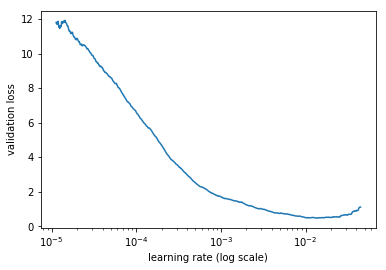

In [781]:
m.sched.plot()

### SAMPLE

In [782]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [783]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.265047   0.382747   inf       
    1      0.186236   0.400334   inf                            
    2      0.152856   0.369505   inf                            


[array([0.36951]), inf]

m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

### ALL

m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

m.fit(lr, 1, metrics=[exp_rmspe])

m.fit(lr, 3, metrics=[exp_rmspe])

m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

### TEST

m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

m.fit(lr, 3, metrics=[exp_rmspe])

m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

m.save('val0')
m.load('val0')
x,y=m.predict_with_targs()
exp_rmspe(x,y)
pred_test=m.predict(True)
pred_test = np.exp(pred_test)
joined_test['Sales']=pred_test
csv_fn=f'{PATH}tmp/sub.csv'
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)
FileLink(csv_fn)

### RANDOM FORREST TEST

from sklearn.ensemble import RandomForestRegressor

((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)